In [1]:
from IPython.display import Latex

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (9, 6)

import numpy as np

from scipy.optimize import curve_fit
from scipy.constants import hbar, m_p, e

In [2]:
mKr = 83.798
mu = mKr / (mKr + 1) * m_p

In [3]:
epsilon = 5.9 # meV
sigma = 3.18 # Å

Rmax = 25

# alpha = 2m / hbar^2
alpha = 2 * mu / hbar**2 * sigma**2*1e-20 * epsilon*1e-3*e
display(Latex(f'$\\frac{{\\hbar^2}}{{2 m}} = {1 / alpha:.4f}$'))

# Lennard-Jones potential combined with centrifugal potential
def Veff_lj(r, l):
    return 4*alpha*((1/r)**12 - (1/r)**6) + l*(l+1) / r**2

<IPython.core.display.Latex object>

In [4]:
# solution for exercise 5
b = (4 / 25 * alpha)**(1/10)

def u(r):
    return np.exp(- b**5 / r**5)

# minimum value for which u(r) > 0 (due to computational limitation on floating numbers)
# r_min = np.linspace(1e-2, 1, 100)[np.where(u(np.linspace(1e-2, 1, 100)) > 0)[0][0] + 3]
r_min = 0.4

def numerov(u, V, E, dr):
    # Numerov method: u and V must be lists or arrays
    k2 = E - V
    for n in range(1, len(u)-1):
        # Numerov formula
        u[n+1] = u[n]*(2-5*dr**2*k2[n]/6) - u[n-1]*(1+dr**2*k2[n-1]/12)
        u[n+1] = u[n+1] / (1 + dr**2*k2[n+1]/12)
    return u

In [5]:
def wf_scatt(e, l, rgrid):
    dr = (max(rgrid) - min(rgrid)) / len(rgrid)
    
    # boundary conditions Numerov method
    wf = np.zeros(len(rgrid))
    wf[0] = np.exp(- b**5 / rgrid[0]**5)
    wf[1] = np.exp(- b**5 / rgrid[1]**5)
    
    # compute wf with Numerov method
    wf = numerov(wf, Veff_lj(rgrid, l), e*alpha, dr)
    return wf


def bessel(l, x):
    if l == 0:
        return np.sin(x) / x
    if l == 1:
        return np.sin(x)/(x**2) - np.cos(x)/x
    return (2*l - 1)/x * bessel(l-1, x) - bessel(l-2, x)


def neumann(l, x):
    if l == 0:
        return - np.cos(x)/x
    if l == 1:
        return - np.cos(x)/(x**2) - np.sin(x)/x
    return (2*l - 1)/x * neumann(l-1, x) - neumann(l-2, x)

# from scipy.special import spherical_jn as bessel
# from scipy.special import spherical_yn as neumann

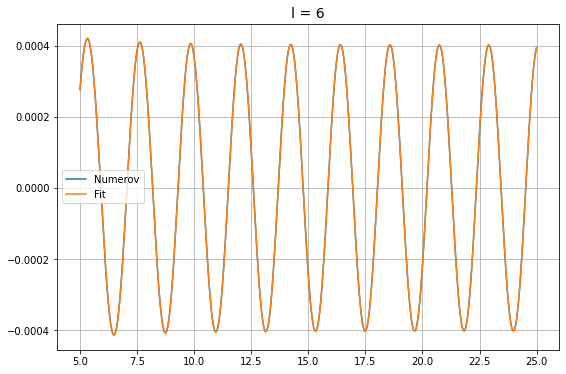

In [6]:
rgrid = np.linspace(r_min, Rmax, 10000)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

for l in range(7):
    wf = wf_scatt(E, l, rgrid)
    
    # fitting function for l
    def u_fit(r, C, delta):
        return C * r * (np.cos(delta)*bessel(l, k*r) - np.sin(delta)*neumann(l, k*r))
    
    # finding delta_l via fit
    popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
    perr = np.sqrt(np.diag(pcov))
    
    if l == 6:
        plt.plot(rgrid[rmax:], wf[rmax:], label='Numerov')
        plt.plot(rgrid[rmax:], u_fit(rgrid[rmax:], *popt), label='Fit')
        plt.title(f'l = {l}', fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()

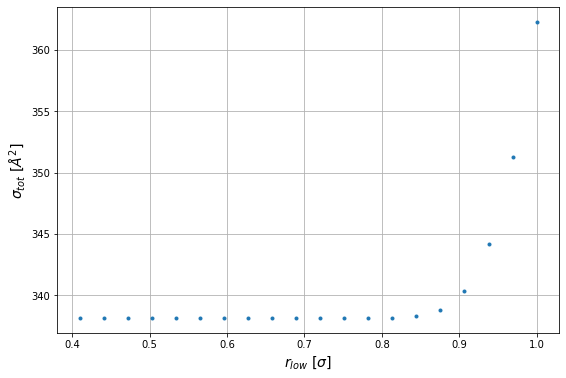

In [7]:
cross = np.zeros((20, 2))
r_lows = np.linspace(r_min+1e-2, 1, 20)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

# iterate over possible values of rlow
for ind, r_low in enumerate(r_lows):
    for l in range(7):
        rgrid = np.linspace(r_low, Rmax, 10000)
        wf = wf_scatt(E, l, rgrid)
        
        # fitting function for l
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*bessel(l, k*r) - np.sin(delta)*neumann(l, k*r))

        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # computer cross section and its error
        cross[ind] += ((2*l + 1) * np.sin(popt[1])**2, (2*l + 1) * np.sin(2*popt[1])*perr[1])
    cross[ind] *= 4 * np.pi / k**2

plt.errorbar(r_lows, cross[:, 0]*sigma**2, fmt='.', yerr=cross[:, 1]*sigma**2)
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('$r_{low}$ [$\\sigma$]', fontsize=14)
plt.grid()
plt.show()

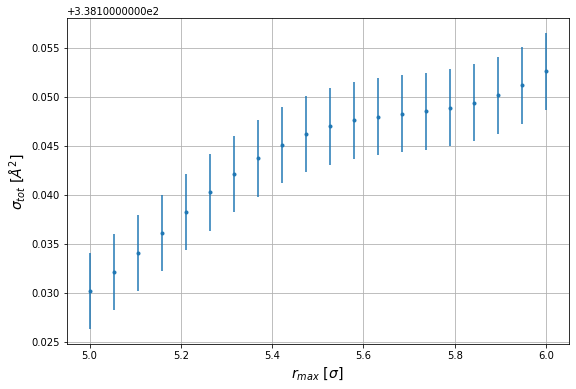

In [8]:
cross = np.zeros((20, 2))
r_maxs = np.linspace(5, 6, 20)

E = 0.3 # epsilon
k = np.sqrt(E * alpha)

# iterate over possible values of r_max
for ind, _r_max in enumerate(r_maxs):
    for l in range(7):
        rgrid = np.linspace(r_min, Rmax, 10000)
        wf = wf_scatt(E, l, rgrid)
        
        # obtain index for r > rmax
        rmax = np.where(rgrid > _r_max)[0][0]
        
        # fitting function for l
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*bessel(l, k*r) - np.sin(delta)*neumann(l, k*r))

        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # computer cross section and its error
        cross[ind] += ((2*l + 1) * np.sin(popt[1])**2, (2*l + 1) * np.sin(2*popt[1])*perr[1])
    cross[ind] *= 4 * np.pi / k**2

plt.errorbar(r_maxs, cross[:, 0]*sigma**2, fmt='.', yerr=cross[:, 1]*sigma**2)
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('$r_{max}$ [$\\sigma$]', fontsize=14)
plt.grid()
plt.show()

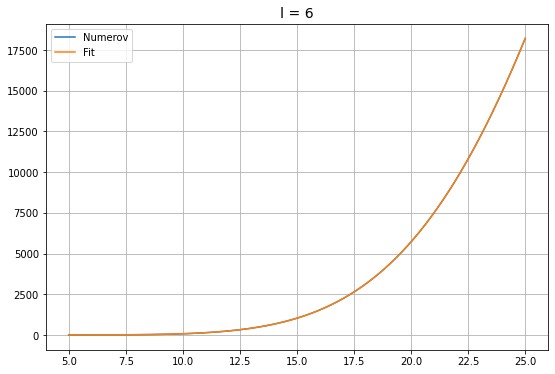

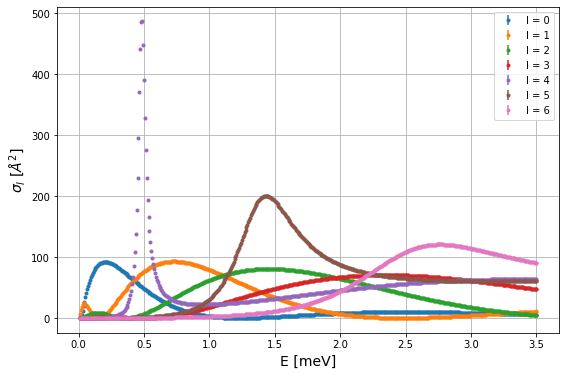

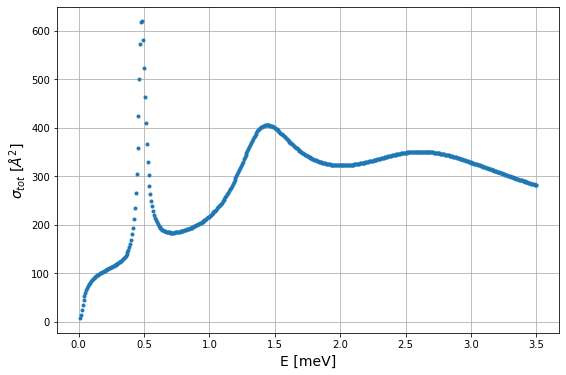

In [9]:
E = np.linspace(0.01, 3.5, 500) / epsilon
cross = np.zeros((500, 7, 2))

rgrid = np.linspace(0.4, Rmax, 10000)

# obtain index for r > 5
rmax = np.where(rgrid > 5)[0][0]

# iterate over possible values of energy
for ind, e in enumerate(E):
    for l in range(7):
        # compute wave function
        wf = wf_scatt(e, l, rgrid)
        
        # fitting function for l
        k = np.sqrt(e * alpha)
        def u_fit(r, C, delta):
            return C * r * (np.cos(delta)*bessel(l, k*r) - np.sin(delta)*neumann(l, k*r))
        
        # finding delta_l via fit
        popt, pcov = curve_fit(u_fit, rgrid[rmax:], wf[rmax:])
        perr = np.sqrt(np.diag(pcov))
        
        # computer cross section and its error
        cross[ind, l] += ((2*l + 1) * np.sin(popt[1])**2, (2*l + 1) * np.sin(2*popt[1])*perr[1])
        
        if l == 6 and ind == 0: 
            plt.plot(rgrid[rmax:], wf[rmax:], label='Numerov')
            plt.plot(rgrid[rmax:], u_fit(rgrid[rmax:], *popt), label='Fit')
            plt.title(f'l = {l}', fontsize=14)
            plt.legend()
            plt.grid()
            plt.show()
            
    cross[ind] *= 4 * np.pi / k**2

for l in range(7):
    plt.errorbar(E*epsilon, cross[:, l, 0]*sigma**2, yerr=cross[:, l, 1]*sigma**2, fmt='.', label=f'l = {l}')

plt.ylabel('$\\sigma_{l}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('E [meV]', fontsize=14)
plt.grid()
plt.legend()
plt.show()

cross = np.sum(cross, axis=1)
plt.errorbar(E*epsilon, cross[:, 0]*sigma**2, yerr=cross[:, 1]*sigma**2, fmt='.')
plt.ylabel('$\\sigma_{tot}$ [$\\AA^2$]', fontsize=14)
plt.xlabel('E [meV]', fontsize=14)
plt.grid()
plt.show()

In [15]:
res0 = cross[:, 0][:100].argmax()
res1 = cross[:, 0][100:300].argmax() + 100
res2 = cross[:, 0][300:].argmax() + 300

dE = (E[1] - E[0])*epsilon
display(Latex(f'$E_{{res}}^0 = ({E[res0]*epsilon:.3f} \pm {dE:.3f})$ meV'))
display(Latex(f'$E_{{res}}^1 = ({E[res1]*epsilon:.3f} \pm {dE:.3f})$ meV'))
display(Latex(f'$E_{{res}}^2 = ({E[res2]*epsilon:.3f} \pm {dE:.3f})$ meV'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>